In [4]:
# Get the data from Kaggle:
# !kaggle datasets download -d vishalsubbiah/pokemon-images-and-types

# !mkdir -p ../input/pokemon-images-and-types
# !unzip pokemon-images-and-types.zip -d ../input/pokemon-images-and-types

# Explore the data

Read the images and metadata information, and display examples of images.

In [5]:
import os
import pandas as pd

INPUT_DIR = '../input/pokemon-images-and-types'

pokemon = pd.read_csv(os.path.join(INPUT_DIR, 'pokemon.csv'))
pokemon = pokemon.sort_values(by='Name')

display(pokemon.head())
display(pokemon.describe())
display(pokemon['Type1'].unique())

,Name,Type1,Type2
459,abomasnow,Grass,Ice
62,abra,Psychic,NaN
358,absol,Dark,NaN
616,accelgor,Bug,NaN
680,aegislash-blade,Steel,Ghost


,Name,Type1,Type2
count,809,809,405
unique,809,18,18
top,abomasnow,Water,Flying
freq,1,114,95


array(['Grass', 'Psychic', 'Dark', 'Bug', 'Steel', 'Rock', 'Normal',
       'Water', 'Dragon', 'Electric', 'Poison', 'Fire', 'Fairy', 'Ice',
       'Ground', 'Ghost', 'Fighting', 'Flying'], dtype=object)

printing image of cutiefly


(120, 120, 3)

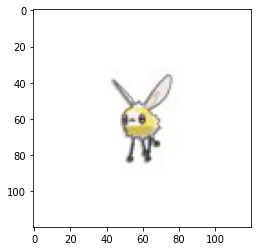

In [7]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def read_img(img_name):
    basename = os.path.basename(img_name)
    
    name, suffix = basename.split('.')
    mdata = matplotlib.image.imread(img_name)
    
    if suffix != 'png':
        mdata = mdata.astype(np.float32) / 255
   
    return (mdata[:,:,:3], name)

mdata, label = read_img(os.path.join(INPUT_DIR, 'images/images/cutiefly.jpg'))

print(f'printing image of {label}')
type(mdata)
display(mdata.shape)
plt.imshow(mdata)

# Preprocessing Data

Create data preprocessing functions that reads in the following data:

- Label data with "Type1" of pokemon metadata, with OneHotEncoding.
- The image data from JPG and PNG files in the images/images directory.

The output data uses a generator to return `(image_data, label)` tuples, and creates `tf.data.Dataset`.

In [8]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
type1 = encoder.fit_transform(pokemon['Type1'].values.reshape((-1, 1)))

display(encoder.categories_)
display(len(encoder.categories_[0]))

[array(['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
        'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
        'Psychic', 'Rock', 'Steel', 'Water'], dtype=object)]

18

In [9]:
display(type1)

print(encoder.inverse_transform(type1)[0])

<809x18 sparse matrix of type '<class 'numpy.float64'>'
	with 809 stored elements in Compressed Sparse Row format>

['Grass']


In [10]:
def get_type1name(name):
    return pokemon[pokemon['Name'] == name]['Type1'].values[0]

def encode_type(type_name):
    return encoder.transform(type_name).toarray()

print('Type1 of pokemon abomasnow:', get_type1name('abomasnow'))
print('Type1 encoding of Grass:', encode_type([['Grass']]))

Type1 of pokemon abomasnow: Grass
Type1 encoding of Grass: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [11]:
# Get the result label information

type1 = encode_type(pokemon['Type1'].values.reshape((-1,1)))

In [12]:
# Create generator for result image data

import os

def gen_train_imgs():
    imglist = os.listdir(os.path.join(INPUT_DIR, 'images/images'))
    
    for i, img in enumerate(imglist):
        imgdata, name = read_img(os.path.join(INPUT_DIR, 'images/images', img))
        type_label = type1[i]
        
        yield (imgdata, type_label)

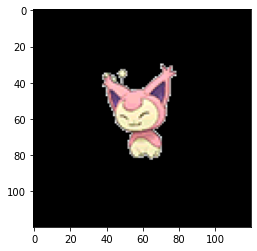

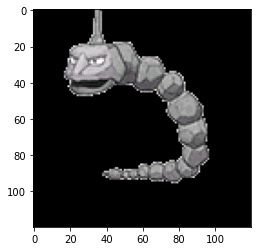

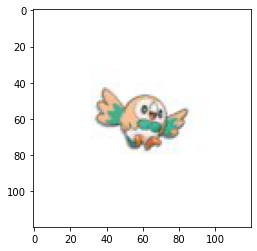

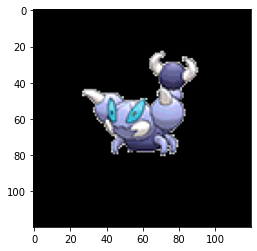

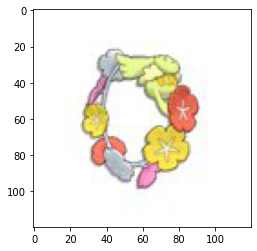

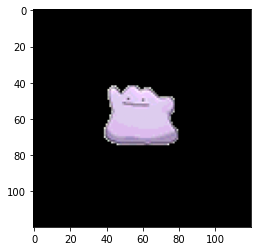

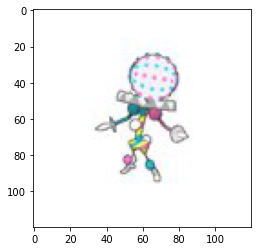

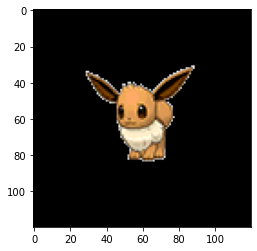

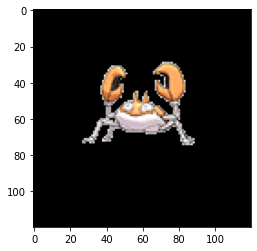

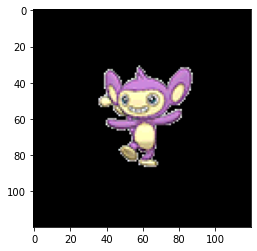

In [13]:
# Test the generator

g = gen_train_imgs()

for i in range(10):
    mdata, label = next(g)
    plt.imshow(mdata)
    plt.show()

In [46]:
import tensorflow as tf

dataset = tf.data.Dataset.from_generator(
    gen_train_imgs,
    output_signature=(
        tf.TensorSpec(shape=(120,120,3), dtype=tf.float32),
        tf.TensorSpec(shape=(18,), dtype=tf.int32),
    ),
)

train_data, val_data = tf.keras.utils.split_dataset(
    dataset.shuffle(32).batch(2), 0.66)

# Create Tensorflow Model

Create CNN model with Tensorflow Keras library, with Convolutional, Maxpooling layers, and output the result vector the shape of (# of classes).

In [59]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

def build_model():
    model = tf.keras.Sequential([
        Conv2D(16, 3, 3, input_shape=(120, 120, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(8, 3, 3, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(18, activation='softmax'),
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 40, 40, 16)        448       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 20, 20, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 6, 6, 8)           1160      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 3, 3, 8)          0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 72)                0         
                                                                 
 dropout_39 (Dropout)        (None, 72)              

In [60]:
history = model.fit(
    train_data, 
    epochs=10,
    validation_data=val_data,
)

Epoch 1/10
267/267 [==============================] - 2s 5ms/step - loss: 2.8697 - accuracy: 0.0655 - val_loss: 2.7549 - val_accuracy: 0.1491
Epoch 2/10
267/267 [==============================] - 1s 4ms/step - loss: 2.7809 - accuracy: 0.0955 - val_loss: 2.7057 - val_accuracy: 0.1491
Epoch 3/10
267/267 [==============================] - 1s 4ms/step - loss: 2.7472 - accuracy: 0.1255 - val_loss: 2.7076 - val_accuracy: 0.1491
Epoch 4/10
267/267 [==============================] - 1s 4ms/step - loss: 2.7411 - accuracy: 0.1330 - val_loss: 2.6997 - val_accuracy: 0.1491
Epoch 5/10
267/267 [==============================] - 1s 4ms/step - loss: 2.7285 - accuracy: 0.1292 - val_loss: 2.6985 - val_accuracy: 0.1491
Epoch 6/10
267/267 [==============================] - 1s 4ms/step - loss: 2.7267 - accuracy: 0.1292 - val_loss: 2.7027 - val_accuracy: 0.1491
Epoch 7/10
267/267 [==============================] - 1s 4ms/step - loss: 2.7292 - accuracy: 0.1273 - val_loss: 2.7005 - val_accuracy: 0.1491
Epoch 